# **Sentiment Analysis**

This project is to conduct sentiment analysis on Amazon Fashion reviews, to classify the reviews into 'positive', 'negative', 'neutral' category. 

In the first step Natural language processing is used, more specifically the VADER approach. Here the data is analysed and given numeric socres of positive, negative, neutral and a combimed weight of the three, called compound. 
Furthermore, the compound scores are used to label the individual reviews as, 'positive', 'negative', and 'neutral' 

In the second step a Machine learning model is developed based on the 'vader-lables'. This is achieved by utilising NLP process of TF-IDF (Text Frequency - Inverse Document Frequency), which converts the text from the reviews into numerical values, which are furhter used to train a SVM model. 

In the third step VADER scores and the ML score will be comepared to see the performance of the created model.

Lastly we will draw conclusions about the model performance and see how it can be improved in the future.


In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk


In [49]:
from pathlib import Path

# Folders relative to the notebook (which lives in /notebooks)
OUTPUT_DIR = Path("../outputs/figures"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = Path("../reports"); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# One-time resource (safe to run every time)
import nltk; nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ankitwalimbe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:

DATA_PATH = Path("../data/raw/Amazon_Fashion.jsonl")
data = pd.read_json(DATA_PATH, lines=True)


In [51]:
# Data Exploration 

data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True
1,5,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True
2,2,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23 01:33:48.000,3,True
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31 20:57:27.095,2,True
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13 14:29:26.000,0,True


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500939 entries, 0 to 2500938
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title              object        
 2   text               object        
 3   images             object        
 4   asin               object        
 5   parent_asin        object        
 6   user_id            object        
 7   timestamp          datetime64[ns]
 8   helpful_vote       int64         
 9   verified_purchase  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 174.1+ MB


In [53]:
data.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

In [54]:
# Converting datetime 

data['timestamp'] = pd.to_datetime(data['timestamp'])

data['date'] = data['timestamp'].dt.date
data['time'] = data['timestamp'].dt.time

# Filtering columns that are necessary for the sentiment analysis. 
selected_columns = ['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date','time']
filt_data = data[selected_columns]

filt_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26


In [55]:
# Exploring the data

print(filt_data['rating'].value_counts())

rating
5    1426268
4     352327
1     303411
3     245471
2     173462
Name: count, dtype: int64


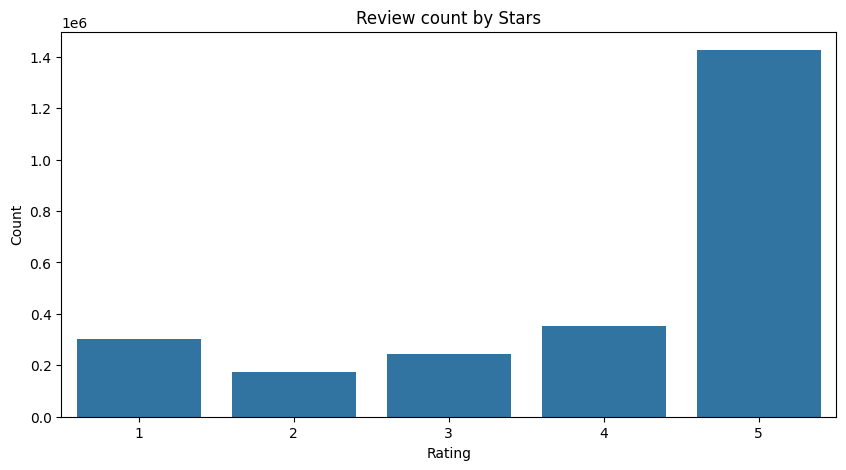

In [56]:
# Visualising this data

plt.figure(figsize = (10,5))
sns.barplot(x = filt_data['rating'].value_counts().index, y = filt_data['rating'].value_counts().values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Review count by Stars")
plt.show()

In [57]:
# Checking for null values

print(filt_data.isnull().sum())

rating         0
title          0
text           0
asin           0
parent_asin    0
user_id        0
date           0
time           0
dtype: int64


**VADER Analysis** 

VADER stands for Valence Aware Dictionary and sEntiment Reasoner, it uses Bag of word approach, where the text to be analysed is broken down to its original components.

In [58]:
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

sscore = SentimentIntensityAnalyzer()

In [59]:
# Applying sentiment analysis to the entire dataset

sentiment_scores_vader = [sscore.polarity_scores(text) for text in tqdm(filt_data['text'], desc = "Processing Sentiment")]
vader_df = pd.DataFrame(sentiment_scores_vader)
filt_data = pd.concat([filt_data,vader_df], axis = 1)


Processing Sentiment: 100%|██████████| 2500939/2500939 [11:20<00:00, 3675.62it/s]


In [60]:
print(filt_data [['text','rating','neg','neu','pos','compound']].head())

                                                text  rating    neg    neu  \
0  I think this locket is really pretty. The insi...       5  0.039  0.750   
1                                              Great       5  0.000  0.000   
2  One of the stones fell out within the first 2 ...       2  0.000  1.000   
3  Crappy socks. Money wasted. Bought to wear wit...       1  0.325  0.574   
4  I LOVE these glasses!  They fit perfectly over...       5  0.000  0.684   

     pos  compound  
0  0.211    0.8532  
1  1.000    0.6249  
2  0.000    0.0000  
3  0.100   -0.6908  
4  0.316    0.9675  


In [61]:
# Before visuliasing the sentiment distribution,
# we add a new column "sentiment_label" based on the compund scores from VADER analysis

def classify_sentiment (scores):
    conditions = [ scores >= 0.05, scores <= -0.05 #Positive and Negative respectively
    ]
    choices = ["positive","negative"]
    return np.select(conditions, choices, default = "neutral")

# Applying the classification function to the dataset
filt_data['vader_sentiment'] = classify_sentiment(filt_data['compound'].values)


In [62]:
filt_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time,neg,neu,pos,compound,vader_sentiment
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000,0.039,0.750,0.211,0.8532,positive
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000,0.000,0.000,1.000,0.6249,positive
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48,0.000,1.000,0.000,0.0000,neutral
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000,0.325,0.574,0.100,-0.6908,negative
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26,0.000,0.684,0.316,0.9675,positive


/var/folders/kh/vgkjbf310bq1psy3lk09mqkr0000gn/T/ipykernel_8019/2054409573.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = filt_data['vader_sentiment'], palette = 'viridis')


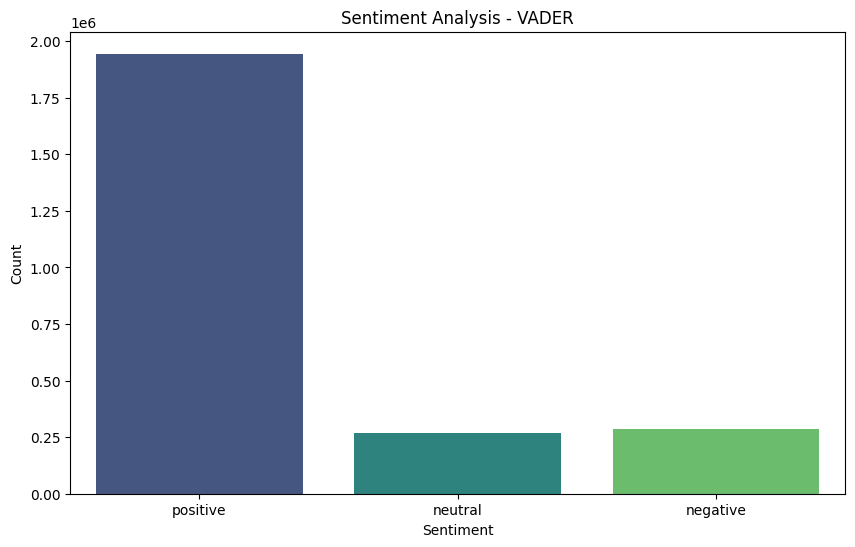

In [63]:
# Visualising the sentiment distribution 

plt.figure(figsize = (10,6))
sns.countplot(x = filt_data['vader_sentiment'], palette = 'viridis')

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Analysis - VADER")
plt.show()

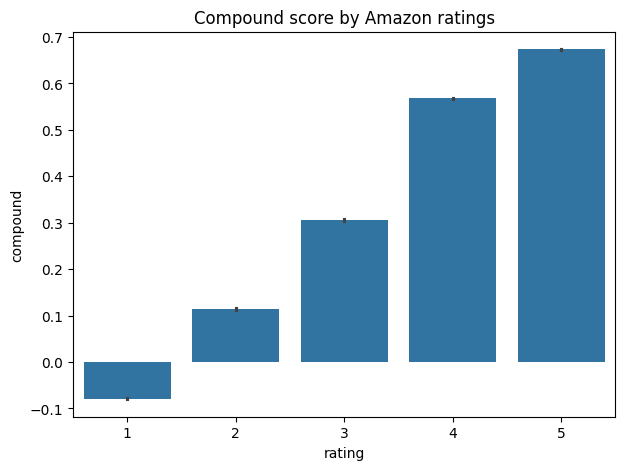

In [64]:
plt.figure(figsize = (7,5))
sns.barplot(data = filt_data, x = 'rating', y = 'compound')
plt.title("Compound score by Amazon ratings")
plt.show()

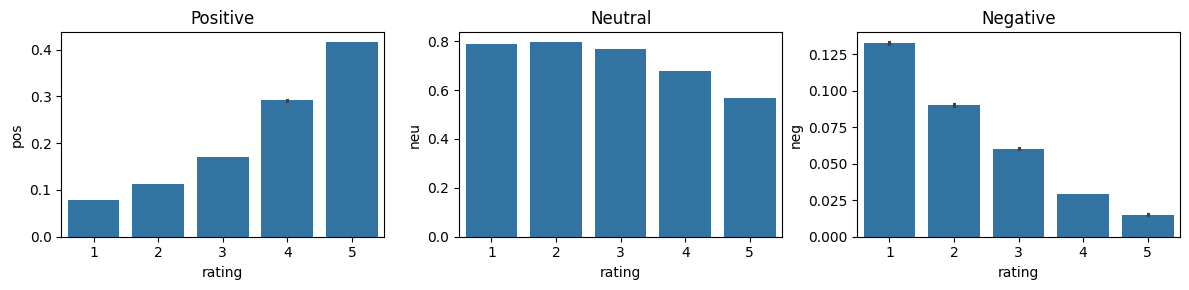

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data= filt_data, x='rating', y='pos', ax=axs[0])
sns.barplot(data= filt_data, x='rating', y='neu', ax=axs[1])
sns.barplot(data= filt_data, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

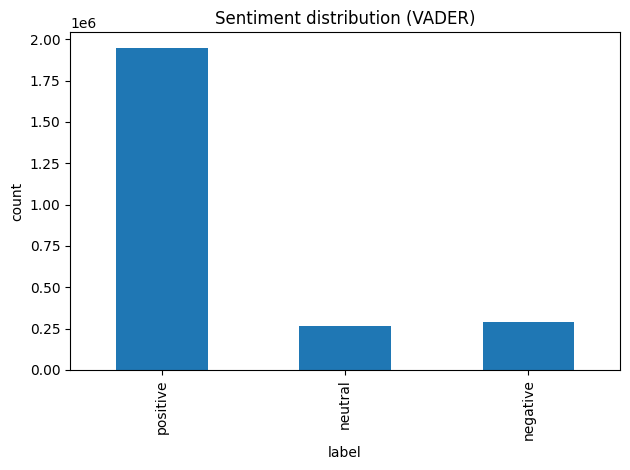

In [66]:
# Saving a light scored sample for review 
cols = ["text","rating","neg","neu","pos","compound","vader_sentiment"]
filt_data[cols].head(1000).to_csv(REPORTS_DIR / "vader_scored_sample.csv", index=False)

# Saving distribution chart
order = ["positive","neutral","negative"]
ax = (filt_data["vader_sentiment"].value_counts()
      .reindex(order).plot(kind="bar"))
ax.set_title("Sentiment distribution (VADER)")
ax.set_xlabel("label"); ax.set_ylabel("count")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "sentiment_distribution_vader.png", dpi=180)
plt.show()


Now with Vader analysis done we create and train an ML model to compare the sentiment recognition performance of VADER approcah with that of a process which uses TF-IDF + ML. 

TF-IDF stands for Term Frequency-Inverse Document Frequency, the methond using NLP converts text to numerical values. 

In [67]:
'''from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text to numerical values
from sklearn.model_selection import train_test_split # To split the data for ML-model trainig 

from sklearn.svm import SVC  # ML-model 
from sklearn.metrics import classification_report, accuracy_score # To evaluate the model performance'''

'from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text to numerical values\nfrom sklearn.model_selection import train_test_split # To split the data for ML-model trainig \n\nfrom sklearn.svm import SVC  # ML-model \nfrom sklearn.metrics import classification_report, accuracy_score # To evaluate the model performance'

In [68]:
ml_data = filt_data.copy() # Creating an independent copy of the dataset for better usability 

ml_data.head()

,rating,title,text,asin,parent_asin,user_id,date,time,neg,neu,pos,compound,vader_sentiment
0,5,Pretty locket,I think this locket is really pretty. The insi...,B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09,00:06:34.489000,0.039,0.750,0.211,0.8532,positive
1,5,A,Great,B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20,01:04:06.701000,0.000,0.000,1.000,0.6249,positive
2,2,Two Stars,One of the stones fell out within the first 2 ...,B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,2015-05-23,01:33:48,0.000,1.000,0.000,0.0000,neutral
3,1,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,2018-12-31,20:57:27.095000,0.325,0.574,0.100,-0.6908,negative
4,5,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-08-13,14:29:26,0.000,0.684,0.316,0.9675,positive


In [69]:
ml_data.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date',
       'time', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment'],
      dtype='object')

In [70]:
print(ml_data["vader_sentiment"].value_counts())

vader_sentiment
positive    1944921
negative     287955
neutral      268063
Name: count, dtype: int64


In [71]:
ml_data["sentiment"] = ml_data["vader_sentiment"]

ml_data.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id', 'date',
       'time', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment',
       'sentiment'],
      dtype='object')

              precision    recall  f1-score   support

    negative       0.71      0.62      0.66     57591
     neutral       0.67      0.90      0.76     53613
    positive       0.96      0.93      0.94    388984

    accuracy                           0.89    500188
   macro avg       0.78      0.82      0.79    500188
weighted avg       0.90      0.89      0.89    500188



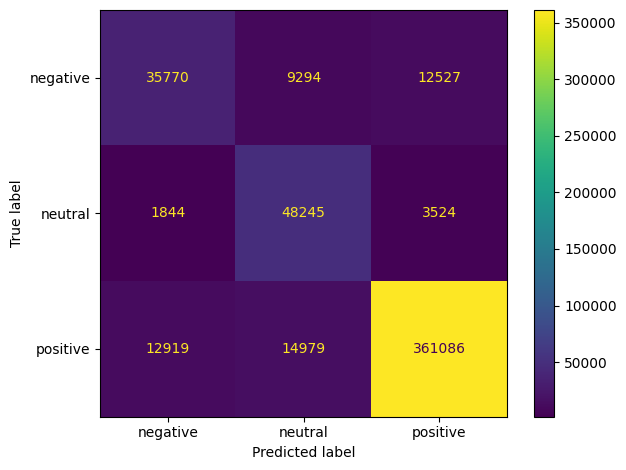

In [75]:
# Training and predicting

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    ml_data["text"], ml_data["vader_sentiment"],
    test_size=0.2, stratify=ml_data["vader_sentiment"], random_state=1
)

clf = make_pipeline(
    TfidfVectorizer(max_features=20000, stop_words="english", min_df=5, ngram_range=(1,2)),
    SGDClassifier(loss="hinge", class_weight="balanced", random_state=1)
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix_vader_replication.png", dpi=180)
plt.show()



Classification Report (ML replicating VADER):

              precision    recall  f1-score   support

    negative      0.708     0.621     0.662     57591
     neutral      0.665     0.900     0.765     53613
    positive      0.957     0.928     0.943    388984

    accuracy                          0.890    500188
   macro avg      0.777     0.816     0.790    500188
weighted avg      0.897     0.890     0.891    500188



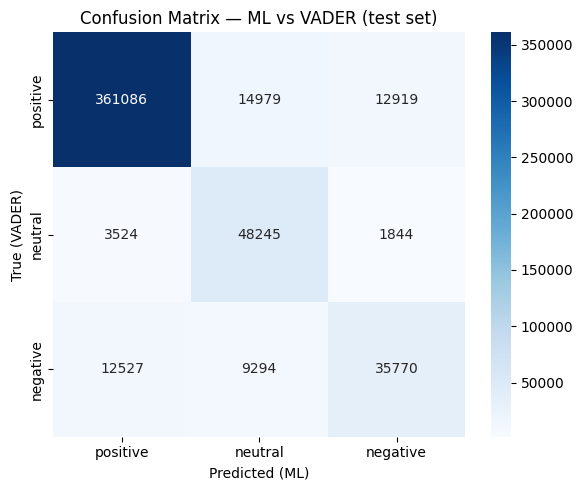

Agreement (ML vs VADER labels, test set): 88.99%


In [76]:
# from sklearn.metrics import classification_report, confusion_matrix
# Evaluattion and confustion matrix
print("\nClassification Report (ML replicating VADER):\n")
print(classification_report(y_test, y_pred, digits=3))

# Consistent label order for confusion matrix
labels = np.array(["positive", "neutral", "negative"])
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted (ML)"); plt.ylabel("True (VADER)")
plt.title("Confusion Matrix — ML vs VADER (test set)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix_vader_replication.png", dpi=180)
plt.show()


agreement = (y_test == y_pred).mean()
print(f"Agreement (ML vs VADER labels, test set): {agreement:.2%}")


In [77]:

comparison_df = pd.DataFrame({
    "text": X_test,                    # X_test is a Series in this pipeline
    "VADER_Sentiment": y_test,
    "ML_Model_Sentiment": y_pred
})
comparison_df.head(1000).to_csv(REPORTS_DIR / "vader_vs_ml_comparison_sample.csv", index=False)


In [78]:
sentiment_counts = ml_data['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    1944921
negative     287955
neutral      268063
Name: count, dtype: int64


# Comapring the model predictions with VADER

In [79]:
'''comparison_df = pd.DataFrame({
    "text": X_test,                     # Series of raw texts from the split
    "VADER_Sentiment": y_test,          # test labels (VADER)
    "ML_Model_Sentiment": y_pred        # pipeline predictions
})
comparison_df.head(1000).to_csv(REPORTS_DIR / "vader_vs_ml_comparison_sample.csv", index=False)
comparison_df.head()'''

'comparison_df = pd.DataFrame({\n    "text": X_test,                     # Series of raw texts from the split\n    "VADER_Sentiment": y_test,          # test labels (VADER)\n    "ML_Model_Sentiment": y_pred        # pipeline predictions\n})\ncomparison_df.head(1000).to_csv(REPORTS_DIR / "vader_vs_ml_comparison_sample.csv", index=False)\ncomparison_df.head()'

In [80]:
# Calculating the percentage of matching sentiment predictions
agreement = (comparison_df["VADER_Sentiment"] == comparison_df["ML_Model_Sentiment"]).mean()
print(f"Agreement Between VADER and ML Model: {agreement:.2%}")

Agreement Between VADER and ML Model: 88.99%


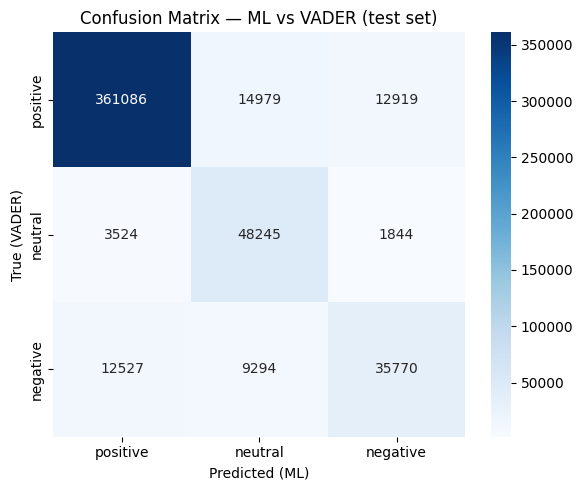

In [81]:

labels = np.array(["positive", "neutral", "negative"])
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted (ML)"); plt.ylabel("True (VADER)")
plt.title("Confusion Matrix — ML vs VADER (test set)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix_vader_replication.png", dpi=180)
plt.show()


In [82]:
# Save Outputs for Repo 

# Save a sample of the comparison DataFrame (first 1000 rows)
comparison_df.head(1000).to_csv(REPORTS_DIR / "vader_vs_ml_sentiment_comparison.csv", index=False)


# Summary & Reflection

What I did: Applied VADER (lexicon-based) to ~23k Amazon Fashion reviews to derive positive/neutral/negative labels; explored relationships with star ratings; saved a scored sample and a distribution figure.
Quick sanity-check: Trained a minimal TF-IDF + linear model to replicate VADER labels on a held-out set; reported macro metrics and a confusion matrix.

What worked:

VADER thresholds gave a fast, explainable baseline.

Clear charts (sentiment distribution, rating vs compound) tell the story quickly.

Saved artifacts (/reports, /outputs/figures) make the project reproducible.

Limitations:

VADER is heuristic; it misses sarcasm and domain slang.

The ML step mirrors VADER rather than human labels, so it validates features—not “true” sentiment.

Next steps (DA/BA-friendly):

Segment sentiment by product type/brand/time to find where negatives cluster.

Extract top n-grams for negatives to surface drivers (fit, quality, delivery).

If needed, compare VADER vs a simple rules baseline and report macro-F1.

Takeaways: Split-first-transform-later (avoid leakage), prefer macro-F1 + confusion matrix over accuracy for skewed data, and always save artifacts for stakeholders.